# **Project Name** : Tourism Experience Analytics: Classification, Prediction, and Recommendation System





# **Project Summary -**

* This project develops a Personalized Tourism Attraction Recommendation System that suggests relevant travel destinations to users based on their historical behavior and preferences.There total nine datasets and are converted to one dataset and dataset contains approximately 33,000 users and includes features such as attraction name, rating, city, region, country, attraction type, and visit mode (e.g., solo, family, couple). To ensure accuracy, each attraction was uniquely identified using a composite key (Attraction + City + Region), preventing duplication of similarly named locations across different geographies. The system first constructs a user–item interaction matrix and applies dimensionality reduction using Singular Value Decomposition (SVD) to uncover latent behavioral patterns among users and attractions(Recommendation System).

* The recommendation engine integrates three approaches: Collaborative Filtering, which predicts attractions based on similar user behavior; Content-Based Filtering, which recommends attractions with similar characteristics (type and region) to those previously visited; and a Popularity Model, which accounts for highly rated and frequently visited destinations. These components are combined into a weighted Hybrid Model that ranks attractions using normalized scores and cosine similarity re-ranking. The system also removes already visited attractions and handles cold-start users by suggesting popular destinations.

* The final solution is deployed using Streamlit, providing an interactive web interface where users can select recommendation types and receive ranked results. The model is scalable, efficient for large datasets, and production-ready. Overall, the project demonstrates practical implementation of recommender system techniques to enhance user experience in the tourism domain by delivering accurate, personalized, and geographically precise attraction suggestions.

# **Problem Statement**


**Tourism agencies and travel platforms aim to enhance user experiences by leveraging data to provide personalized recommendations, predict user satisfaction, and classify potential user behavior. This project involves analyzing user preferences, travel patterns, and attraction features to achieve three primary objectives: regression, classification, and recommendation.**

# ***Data Wrangling***

### **Import Libraries**

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# connect with google drive
import google as g
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Dataset Loading**


In [3]:
# Fetch all the data.

City = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/City.xlsx')
Continent = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/Continent.xlsx')
Country = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/Country.xlsx')
Item = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/Item.xlsx')
Mode = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/Mode.xlsx')
Region = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/Region.xlsx')
Transaction = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/Transaction.xlsx')
Type = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/Type.xlsx')
User = pd.read_excel('/content/drive/MyDrive/Tourism Experience Analysis/Datasets/User.xlsx')

There are total nine datasets such as,
```
Item(contain data about attraction places),

Transaction(contain Information about user like visiting time, tourist rating, etc),

Type(contain attraction place type like nature, museum, monumnet, ect),

Mode(tourist visiting mode like family, couple, solo, etc),

Region, Continent, Country, City(Contain some geographical information),

User(contain unique identifier of all this tables)
```

In [4]:
# check for the data.
City.head()

,CityId,CityName,CountryId
0,0,-,0
1,1,Douala,1
2,2,South Region,1
3,3,N'Djamena,2
4,4,Kigali,3


**There are some tables like City, Country, Continent, Region, Mode in which first row dosen't contain information so we need to remove it.**

In [5]:
# Remove 0th indexed elemnts from some tables.

City = City[City['CityId'] != 0]
Country = Country[Country['CountryId'] != 0]
Continent = Continent[Continent['ContinentId'] != 0]
Region = Region[Region['RegionId'] != 0]
Mode = Mode[Mode['VisitModeId'] != 0]

Now we have preseve data which not contain Id = 0.

In [6]:
# change column name in some datasets.

City = City.rename(columns={'Name': 'CityName'})
Country = Country.rename(columns={'Name': 'CountryName'})
Region = Region.rename(columns={'Name': 'RegionName'})
Continent = Continent.rename(columns={'Name': 'ContinentName'})

We need to change some column name "Name" which same in different datasets like City, Country, Region and Contient.

In [7]:
# Merge all the datasets.
df = Transaction.merge(User, on='UserId', how='left')

df = df.merge(Item, on='AttractionId', how='left')
df = df.merge(Type, on='AttractionTypeId', how='left')

df = df.merge(City, on='CityId', how='left')
df = df.merge(Country, left_on = 'CountryId_y', right_on = 'CountryId', how='left')
df = df.merge(Region, left_on = 'RegionId_y', right_on='RegionId', how='left')
df = df.merge(Continent, left_on = 'ContinentId_y', right_on='ContinentId', how='left')

df = df.merge(Mode, left_on='VisitModeID', right_on='VisitModeId', how='left')

Tables were merged by starting with the transactional fact table and progressively enriching it with direct and hierarchical dimension tables to preserve row-level integrity and analytical correctness.

In [8]:
# All the columns of the dataset df after merging all the tables.
df.columns

Index(['TransactionId', 'UserId', 'VisitYear', 'VisitMonth', 'VisitModeID',
       'AttractionId', 'Rating', 'ContinentId_x', 'RegionId_x', 'CountryId_x',
       'CityId', 'AttractionCityId', 'AttractionTypeId', 'Attraction',
       'AttractionAddress', 'AttractionType', 'CityName', 'CountryId_y',
       'CountryId', 'Country', 'RegionId_y', 'Region', 'RegionId',
       'ContinentId_y', 'ContinentId', 'Continent', 'VisitModeId',
       'VisitMode'],
      dtype='object')

In [9]:
# Drop columns which is no further important

df.drop(columns=['AttractionAddress','CountryId', 'RegionId_y', 'RegionId', 'ContinentId', 'AttractionId', 'AttractionTypeId', 'CityId', 'CountryId_y', 'VisitModeID', 'ContinentId_x', 'RegionId_x', 'AttractionCityId', 'CountryId_x', 'VisitModeId', 'ContinentId_y'], axis = 1, inplace = True)

Reduce dimenstions of dataset by removing columns which are no more important like unique identifiers exept TrasactionId and UserId because we'll use it in Recommendation system.

### **Dataset First View**

In [10]:
# Dataset First Look
df.head()

,TransactionId,UserId,VisitYear,VisitMonth,Rating,Attraction,AttractionType,CityName,Country,Region,Continent,VisitMode
0,3,70456,2022,10,5,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,Guildford,Australia,Australia,Australia & Oceania,Couples
1,8,7567,2022,10,5,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,Ontario,Canada,Northern America,America,Friends
2,9,79069,2022,10,5,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,Brazil,United States,Northern America,America,Family
3,10,31019,2022,10,3,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,Zurich,Canada,Northern America,America,Family
4,15,43611,2022,10,3,Sacred Monkey Forest Sanctuary,Nature & Wildlife Areas,Manchester,United States,Northern America,America,Couples


### **Dataset Information**

In [11]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52930 entries, 0 to 52929
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionId   52930 non-null  int64 
 1   UserId          52930 non-null  int64 
 2   VisitYear       52930 non-null  int64 
 3   VisitMonth      52930 non-null  int64 
 4   Rating          52930 non-null  int64 
 5   Attraction      52930 non-null  object
 6   AttractionType  52930 non-null  object
 7   CityName        52922 non-null  object
 8   Country         52922 non-null  object
 9   Region          52890 non-null  object
 10  Continent       52890 non-null  object
 11  VisitMode       52930 non-null  object
dtypes: int64(5), object(7)
memory usage: 4.8+ MB



**DATA Description :**

**This dataset is merge of some tables such as Transaction, User, Visit Mode, Region, Attraction place, Attraction Type, Country, City, Continent.**

#### **Columns observed:**

1. TransationId

* Unique identifier for each visitor transaction or record.

2. UserId

* Unique identifier for each visitors.

3. VisitYear

* Year in which the visit to the attraction occurred by each visitor.

4. VisitMonth

* Month of the visitin which the visit to the attraction occurred by each visitor.

5. Rating

* Visitor-provided rating for the attraction (e.g., satisfaction score).

6. Attraction

* Name of the attraction place visited by tourists.

7. AttractionType

* Category or type of attraction (e.g., museum, park, monument).

8. CityName

* Name of the city where the attraction is located.

9. Country

* Country in which the attraction is located.

10. Region

* Geographical region within the country (e.g., state or province).

11. Continent

* Continent where the attraction is located.

12. VisitMode

* Mode of visit (e.g., family, solo, group, business).

#### **Duplicate Values**

In [12]:
# Check duplicate values
df.duplicated().sum()

np.int64(0)

There is no duplicate values in datasets.

#### **Missing Values/Null Values**

In [13]:
# Missing Values/Null Values Count
df.isnull().sum()

,0
TransactionId,0
UserId,0
VisitYear,0
VisitMonth,0
Rating,0
Attraction,0
AttractionType,0
CityName,8
Country,8
Region,40


**A small portion of records lacked complete geographic hierarchy due to missing upstream mappings. These records were retained to preserve transactional integrity and selectively filtered for geography-specific analysis.**

In [14]:
# df[df['Region'].isna()][['Country', 'CityName']].    # These 'Country' and 'CityName' are same.
# df[df['Country'] == df['CityName']][['Country', 'CityName']]  # There are total 3839 row with same 'Country' and 'CityName'.
df.dropna(inplace = True)
df.isnull().sum()

,0
TransactionId,0
UserId,0
VisitYear,0
VisitMonth,0
Rating,0
Attraction,0
AttractionType,0
CityName,0
Country,0
Region,0


I thought to replace null values in 'Continent' and 'Region' using 'CityName' and 'Country' but when i checked 'CityName' and 'Country' are both contains same values so i done simply drop those values which are missing or NaN.

### **What did you know about your dataset?**

**This dataset captures visitor transaction records for tourist attractions, including temporal details, visitor ratings, attraction characteristics, geographical information, and visit mode.**

**There are some similar data in 'CityName' and 'Country' columns.**

## ***Understanding Your Variables***

In [15]:
# Rating distribution
df['Rating'].describe()

,Rating
count,52890.000000
mean,4.157799
std,0.970582
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


The descriptive statistics indicate that visitor ratings are predominantly high, with a mean score of 4.16 and a median of 4, suggesting strong overall satisfaction and moderate variability, while lower ratings occur infrequently.

### What all manipulations have you done?

1. We have fetch datasets using pandas library.
2. Deal with duplicate and null values from the datasets.
3. Exract the description of the datasets.

Now there are no duplicate and null values inside datasets, and are ready for further process.

# ***Data Vizualization***

### Distribution of Restaurant Ratings.

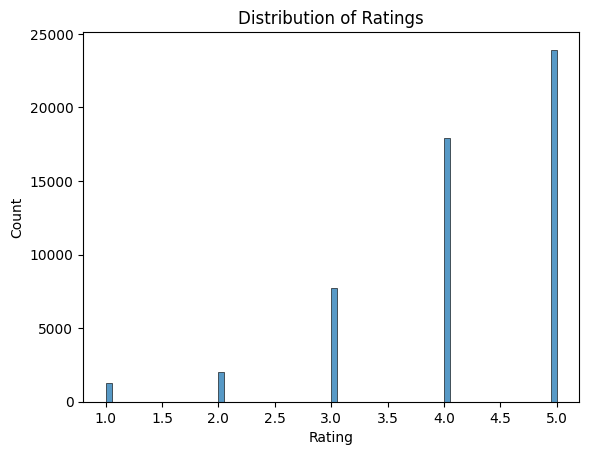

In [16]:
# Tourist Satisfaction score by Rating.

plt.figure()
sns.histplot(data = df, x = 'Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

We can see majority of the data contain highest rating (4 - 5) and only few rating are lower (1 - 2) that means most of the tourists likes attraction places.

The data is highly skewed at higher ratings.

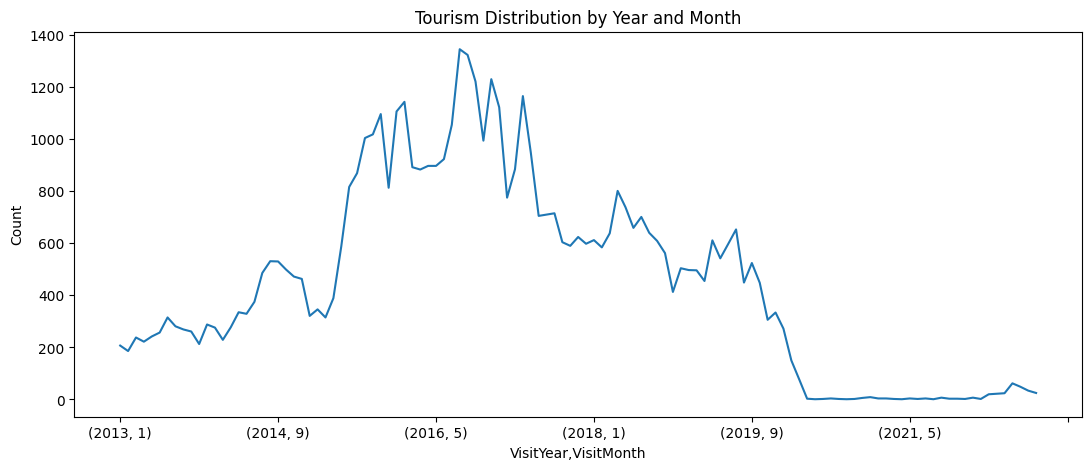

In [17]:
# Tourism distribution by year and month.

plt.figure(figsize = [13, 5])
df.groupby(['VisitYear', 'VisitMonth']).size().plot()
plt.ylabel('Count')
plt.title('Tourism Distribution by Year and Month')
plt.show()

The time-series analysis reveals both temporal growth and seasonal cyclicality. Visit volumes increase year-over-year while exhibiting consistent intra-year peaks, suggesting structurally growing demand influenced by seasonal tourism patterns.

In [18]:
location = df.groupby(['Continent', 'Country', 'CityName'])['TransactionId'].count()
location = location.reset_index(name = 'TransactionCount')
top_cities = location.sort_values('TransactionCount', ascending = False).head(15)

Text(0.5, 1.0, 'Top 15 Cities by Transaction Count')

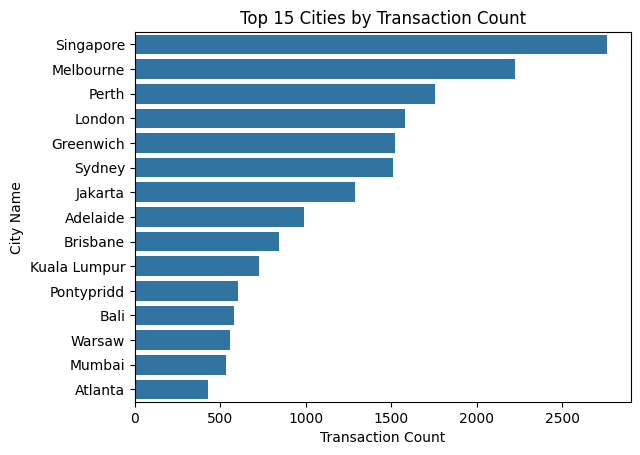

In [19]:
# Top 15 cities which are visited by tourists.

plt.figure()
sns.barplot(data = top_cities, x = 'TransactionCount', y = 'CityName')
plt.xlabel('Transaction Count')
plt.ylabel('City Name')
plt.title('Top 15 Cities by Transaction Count')

* business is getting most of its transactions from just a few cities — mainly Singapore, Melbourne, and Perth.

* At the same time, many cities in the Asia-Pacific region (like Sydney, Jakarta, Kuala Lumpur, Bali) are also performing well. So this region is your strongest market.

* We should not depend too much on only the top 3 cities (it’s risky if demand drops there).

* We should try to grow cities that are already doing moderately well.

* Asia-Pacific is your strongest area, so investing more marketing and offers there can increase growth.

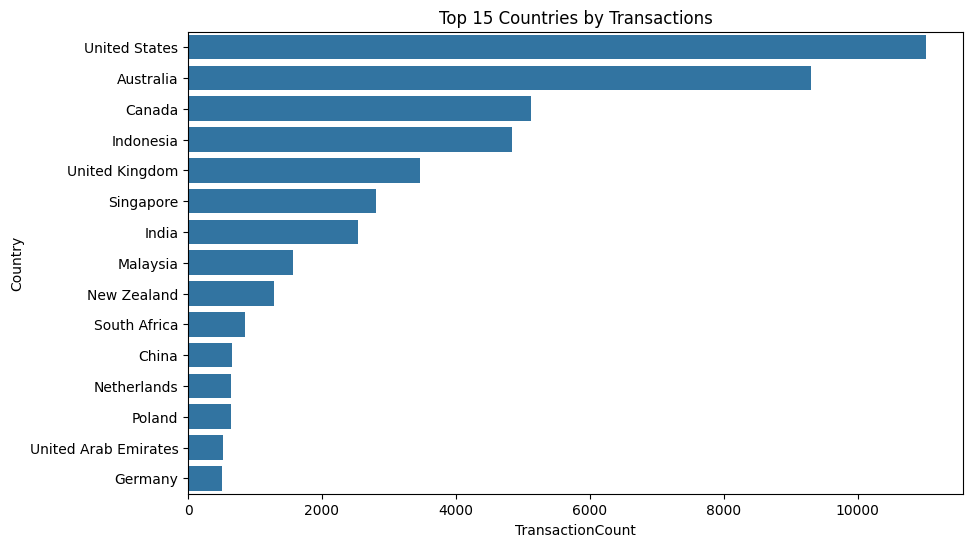

In [20]:
# Most visited Countries.

country_level = location.groupby('Country')['TransactionCount'].sum().reset_index()

top_countries = country_level.sort_values(
    'TransactionCount', ascending=False
).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=top_countries,x='TransactionCount',y='Country')
plt.title('Top 15 Countries by Transactions')
plt.show()

**The transaction distribution is highly skewed toward North America and Australia, indicating strong product-market fit in developed English-speaking regions. However, emerging markets such as India and Southeast Asia show moderate adoption, suggesting significant expansion potential. European markets remain underpenetrated and require localized growth strategies.**

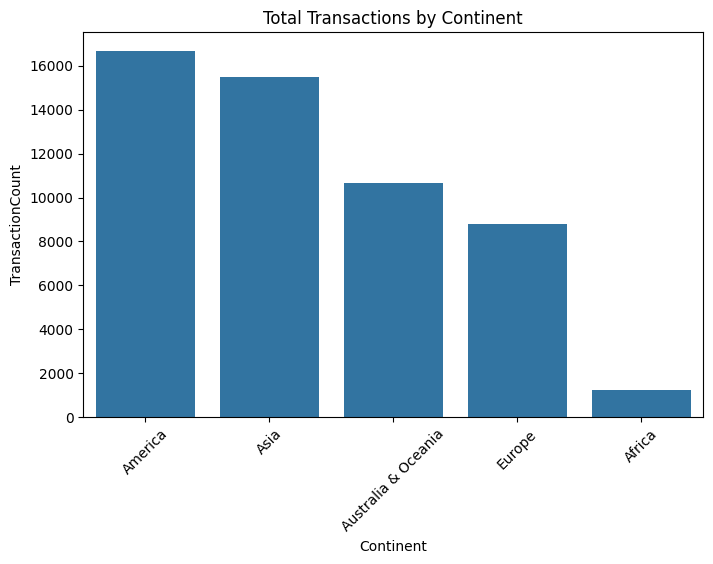

In [21]:
# Continent level distribution.

continent_level = location.groupby('Continent')['TransactionCount'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(
    data=continent_level.sort_values('TransactionCount', ascending=False),
    x='Continent',
    y='TransactionCount'
)
plt.title('Total Transactions by Continent')
plt.xticks(rotation=45)
plt.show()

The geographic analysis reveals that transaction activity is concentrated in specific continents and further dominated by a small number of high-performing cities. While global presence exists, demand distribution is uneven, indicating potential opportunities for strategic expansion in underperforming regions.

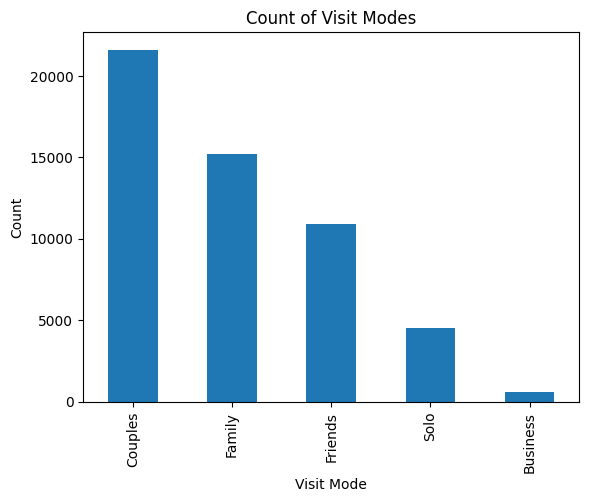

In [22]:
# Distribution by Visit modes

plt.figure()
df['VisitMode'].value_counts().plot(kind = 'bar')
plt.xlabel('Visit Mode')
plt.ylabel('Count')
plt.title('Count of Visit Modes')
plt.show()

The visit mode distribution reveals that transactions are predominantly driven by leisure segments, particularly couples and families. This indicates that the platform’s demand is primarily recreational rather than business-oriented.

The dominance of couple travelers suggests strong preference for experiential and destination-based tourism, while minimal business travel participation highlights potential expansion opportunities in the corporate segment. Strategic focus should therefore align with leisure marketing, seasonal campaigns, and experience-based offerings.

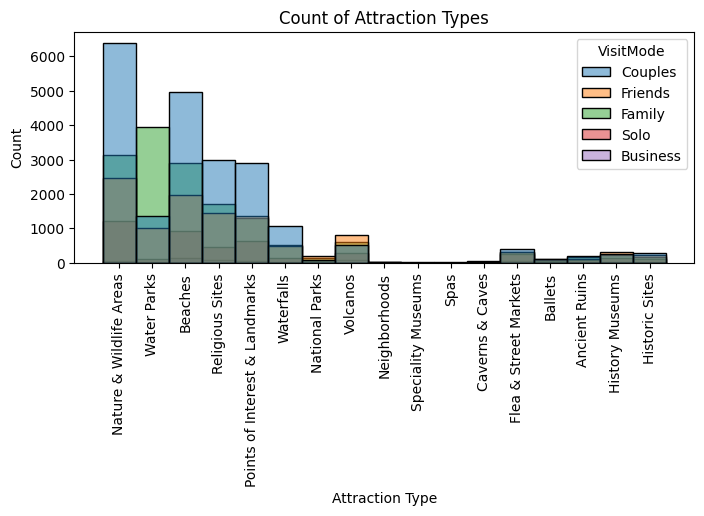

In [23]:
# Distribution of attraction type with visit mode.

plt.figure(figsize = (8,3))
sns.histplot(data = df, x = 'AttractionType', hue = 'VisitMode')
plt.xlabel('Attraction Type')
plt.ylabel('Count')
plt.title('Count of Attraction Types')
plt.xticks(rotation = 90)
plt.show()

* The attraction type distribution indicates a strong customer preference for outdoor and experiential tourism, particularly nature, wildlife, and beach-related attractions.

* Combined with the dominance of couples and family travel segments, this suggests that the platform primarily serves leisure-driven, experience-focused travelers.

* Strategic emphasis should therefore be placed on expanding outdoor tourism offerings, seasonal promotional campaigns, and bundled leisure packages, while niche cultural categories may require targeted marketing to improve engagement.

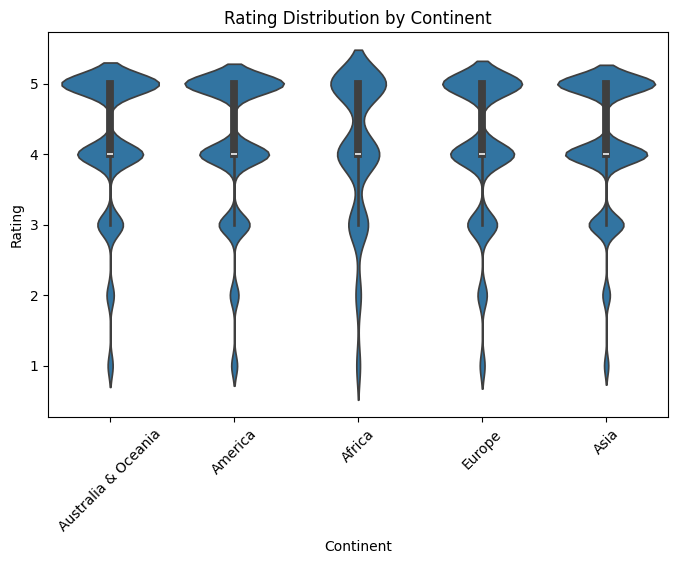

In [24]:
# Rating by Continent.

plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='Continent', y='Rating')
plt.xticks(rotation=45)
plt.title('Rating Distribution by Continent')
plt.show()

The rating distribution across continents demonstrates consistently high customer satisfaction, with ratings predominantly clustered between 4 and 5.

The similarity in distribution across regions indicates stable service quality and standardized user experience globally. This, combined with the dominance of leisure-oriented segments and outdoor attractions, suggests a strong market position in experiential tourism with minimal regional performance gaps.

Text(0.5, 1.0, 'Trend of Attraction Types Over Time')

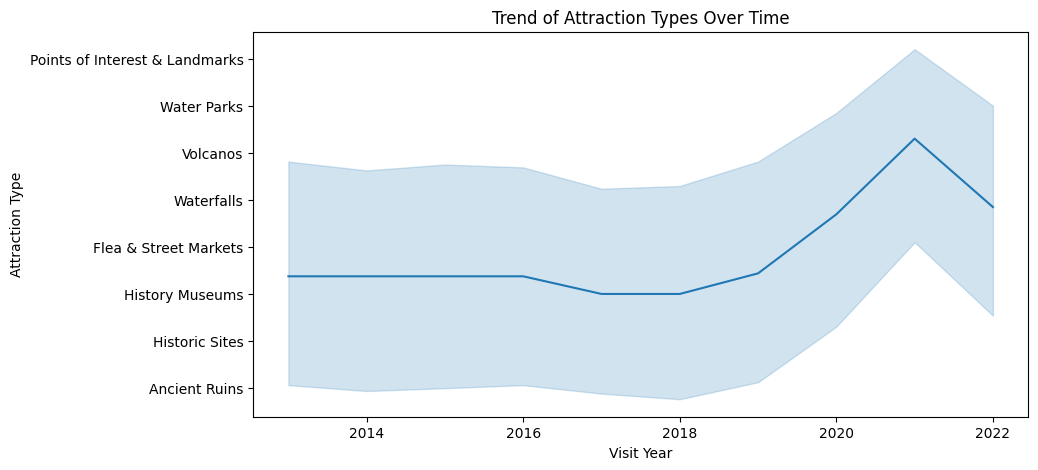

In [25]:
# Attraction Type by Year.

trend = df[['AttractionType', 'VisitYear']].value_counts().reset_index(name = 'Count')

plt.figure(figsize = (10, 5))
sns.lineplot(data = trend, x = 'VisitYear', y = 'AttractionType')
plt.xlabel('Visit Year')
plt.ylabel('Attraction Type')
plt.title('Trend of Attraction Types Over Time')

The time trend indicates overall expansion of attraction demand, with temporary mid-period contraction followed by significant post-2019 acceleration.

The 2021 peak suggests a strong rebound effect, and the sustained higher levels in 2022 indicate a structurally larger market compared to the early years.

# **Hypothesis Testing**

### **Hypothetical Statement - 1 : Does visit Mode affect Ratings?**

Do couples, families, solo travelers, and business travelers give significantly different ratings?

#### **1. State Your research hypothesis as a null hypothesis and alternate hypothesis.**

* H₀ (Null): Mean rating is equal across all visit modes

* H₁ (Alternative): At least one visit mode has a different mean rating

#### **2. Perform an appropriate statistical test.**

In [26]:
# Perform Statistical Test to obtain P-Value

from scipy import stats

groups = [group['Rating'].values for name, group in df.groupby('VisitMode')]

f_stat, p_value = stats.f_oneway(*groups)

print("F-stat:", f_stat)
print("p-value:", p_value)

F-stat: 35.27754921219044
p-value: 1.7890266617506712e-29


p_value = 0 < 0.05 means rejection of null hypothesis(H0)

f state is 35.4 means, the variation between your group means is 35 times larger than the variation within the groups.

### **Hypothetical Statement - 2 : Is Visit Mode Associated with Attraction Type?**

Do different visitor groups prefer different types of attractions?

#### 1. State Your research hypothesis as a null hypothesis and alternate hypothesis.

H₀: Visit mode and attraction type are independent

H₁: They are associated

#### 2. Perform an appropriate statistical test.

In [27]:
# Perform Statistical Test to obtain P-Value

import pandas as pd
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df['VisitMode'], df['AttractionType'])

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square:", chi2)
print("p-value:", p)

Chi-square: 5980.835165640641
p-value: 0.0


**Statistically:**

    Visitor type and attraction choice are highly dependent variables.

**Strategically:**

    A one-size-fits-all offering is inefficient.
    Segment-specific product positioning is justified.


# ***Data Pre-processing***

### Handling Outliers

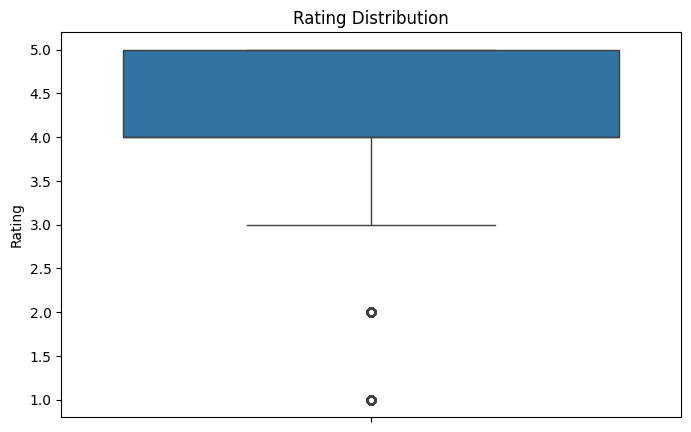

In [28]:
# find the columns which contain outliers

plt.figure(figsize = (8,5))
sns.boxplot(df['Rating'])
plt.title('Rating Distribution')
plt.show()

**Find some outlier in rating but this may contain some insight so better to not remove these ratings.**

### **Standardization and Categorical Encoding**

In [29]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [30]:
new_df = df.copy()

In [31]:
# Standardization.

num_col = new_df.select_dtypes(include = ['int64', 'float64'])
num_col.columns

Index(['TransactionId', 'UserId', 'VisitYear', 'VisitMonth', 'Rating'], dtype='object')

We dont need to standardize These columns ['TransactionId', 'VisitYear', 'VisitMonth', 'Rating'].

In [32]:
# Encode your categorical values in both the datasets.
encoder = LabelEncoder()

def cat_col_encoder(x, cols):
  for col in cols:
    x[col] = encoder.fit_transform(x[col])

  return x

cat_col = new_df.select_dtypes(include = ['object'])

cat_col_encoder(new_df, cat_col).head()

,TransactionId,UserId,VisitYear,VisitMonth,Rating,Attraction,AttractionType,CityName,Country,Region,Continent,VisitMode
0,3,70456,2022,10,5,17,8,1799,6,0,3,1
1,8,7567,2022,10,5,17,8,3507,26,11,1,3
2,9,79069,2022,10,5,17,8,629,141,11,1,2
3,10,31019,2022,10,3,17,8,5461,26,11,1,2
4,15,43611,2022,10,3,17,8,2845,141,11,1,1


We need to encode categorical data to numerical value for ML models.

**Our data is preprocessed.**


# ***ML Model Implementation***


### **Model-1 : Model to predict user satisfaction by user rating.**

In [33]:
# Seprate data and label columns.

X = new_df[['VisitYear', 'VisitMonth', 'Attraction', 'AttractionType', 'CityName', 'Region', 'Continent', 'VisitMode']]
y = new_df['Rating']

In [34]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [35]:
# Import model libraries.

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [36]:
# model implementation and evaluation

def model_eval(model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)

  print('Mean Squared Error :', mse)
  print('Mean Absolute Error :', mae)

  return model

In [37]:
# learning_rate = [0.045, 0.05, 0.055]
# n_estimators = [140, 145, 150, 155, 160]
# max_depth = [5, 6, 7]

In [38]:
# lst = {'lr' : 0, 'n_estim' : 0, 'depth' : 0}
# x,y = 10, 10
# for i in learning_rate:
#   for j in n_estimators:
#     for k in max_depth:
#       model = XGBRegressor(learning_rate = i, n_estimators = j, max_depth = k, random_state = 101)
#       print('learning Rate :', i, 'n_estimators :', j, 'max_depth :', k)
#       mse, mae = model_eval(model)
#       print('\n\n')

#       if x > mse:
#         x = mse
#         y = mae
#         lst = {'lr' : i, 'n_estim' : j, 'depth' : k}


# print(lst)

In [39]:
# XGBoost :
print("XGBoost Regressor :")
model = model_eval(XGBRegressor(learning_rate = 0.055, n_estimators = 155, max_depth = 7))

XGBoost Regressor :
Mean Squared Error : 0.8148552775382996
Mean Absolute Error : 0.7075788378715515


#### There are some models like Random Forest, Gradient Boosting, LightGBM, XGBoost but XGBoost is giving best outcome among othres.  

In [40]:
y_train[:5]

,Rating
8371,5
27166,5
9688,5
26001,5
13402,5


In [41]:
model.predict(X_train[:5])

array([4.333805 , 4.104282 , 4.15994  , 4.0522966, 4.7207212],
      dtype=float32)

### Model-2 : Classify potential user behaviour.

In [42]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 8.5 MB/s eta 0:00:00


In [43]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [44]:
data = new_df[['Continent', 'Country', 'VisitMode', 'AttractionType', 'Attraction']]

In [45]:
# check for duplicate values.

data.duplicated().sum()

np.int64(49549)

Too much duplicate value, we need to remove these duplicate data.

In [46]:
# drop duplicate values.

data.drop_duplicates(inplace = True)
len(data)

3341

Now all the duplicate values are removed.

In [47]:
X = data.drop('Attraction', axis = 1)
y = data['Attraction']

In [48]:
# split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [49]:
# model implementation and evaluation

def model_eval_classifier(model):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)

  print('Accuracy :', acc)
  return model

In [50]:
print('XGBoost Classifier :')
model = model_eval_classifier(XGBClassifier(learning_rate = 0.01, n_estimators = 150, max_depth = 2))

XGBoost Classifier :
Accuracy : 0.6591928251121076


**I have choosed 'Continent', 'Country', 'AttractionType', 'VisitMode' columns to classify Attraction label.**

**For this also i have checked XGBoost, Random Forest, Catboost, LightGBM but XGBoost is giving me highest accuracy which is around 66 %.**

**The resion behind low accuracy is small dataset and also number of labels are 30 and that is little huge number for predicting labels.**

# **Conclusion**

* **The Tourism Recommendation System successfully demonstrates how hybrid recommender system techniques can be applied to deliver accurate and personalized travel suggestions at scale. By combining Collaborative Filtering (SVD-based matrix factorization), Content-Based Filtering, and Popularity-based ranking, the system leverages both user behavior patterns and attraction characteristics to generate high-quality recommendations. The introduction of a unique item identifier (Attraction + City + Region) ensures geographical precision and eliminates ambiguity caused by duplicate attraction names across different locations.**

* **The hybrid scoring strategy, along with cosine similarity re-ranking and removal of previously visited attractions, enhances recommendation relevance and user satisfaction. Additionally, cold-start handling and efficient matrix operations make the system scalable for large datasets (33,000+ users). Deployment through Streamlit provides an interactive and production-ready interface, demonstrating the system’s practical applicability in real-world tourism platforms.**

* **Overall, the project effectively translates recommender system theory into a functional, scalable, and user-centric solution, improving travel discovery through intelligent, data-driven personalization.**